In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Read the CSV file
df = pd.read_csv('Cleaned_Dolche_Vita_Reviews.csv')

# Display basic info
print(df.head())
print("\
Dataset Info:")
print(df.info())

        UserId       Location  Rating  \
0       rbrech  Silver Spring       3   
1      Diane O        Unknown       1   
2          L4Y        Unknown       3   
3  Happy201501      Bradenton       5   
4     jchizzon        Clinton       4   

                                            Headline  \
0                                   Good, not great.   
1                       Valentine's Dinner was AWFUL   
2                     New years eve pre-fixed dinner   
3  A Classic Local Italian Restaurant Maintains i...   
4                       On a recent trip to Northern   

                                              Review       Date  Value Rating  \
0  This is a fine Italian restaurant. Nothing out...  3/14/2020             3   
1  Our Valentine's dinner last night was a comple...  2/14/2020             1   
2  Let me start by saying we usually love this pl...   1/9/2020             4   
3  We returned to Dolce Vita after a lapse of 5 y...   1/6/2020             4   
4  On a rec

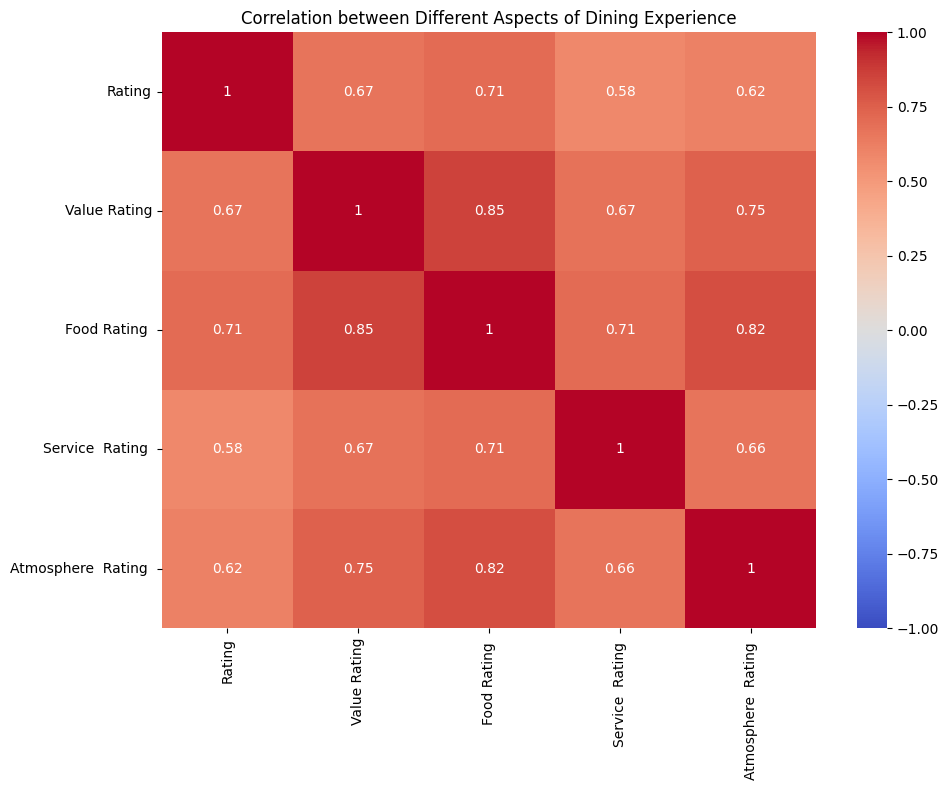

Average Ratings for Each Aspect:
Service  Rating        4.158537
Food Rating            4.112195
Rating                 4.095122
Atmosphere  Rating     4.046341
Value Rating           4.014634
dtype: float64


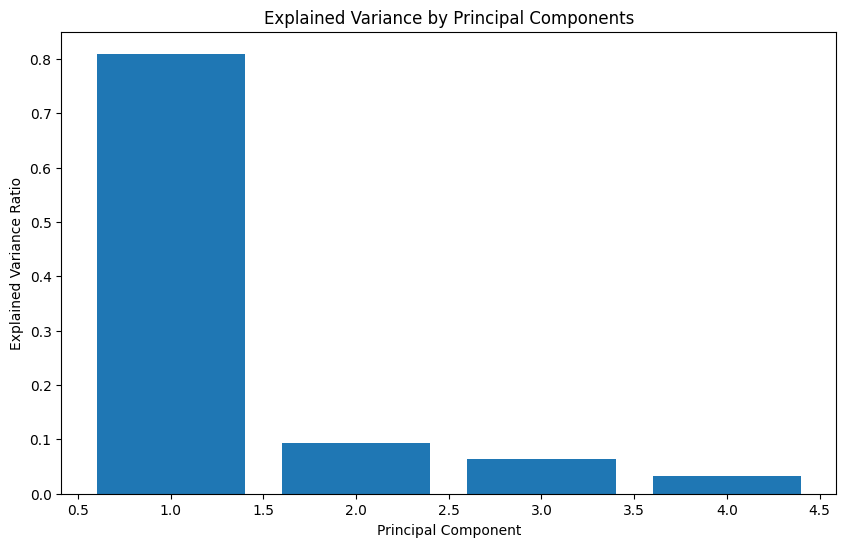

Feature Importance based on First Principal Component:
            Importance
Food          0.524240
Value         0.506865
Atmosphere    0.499725
Service       0.467478


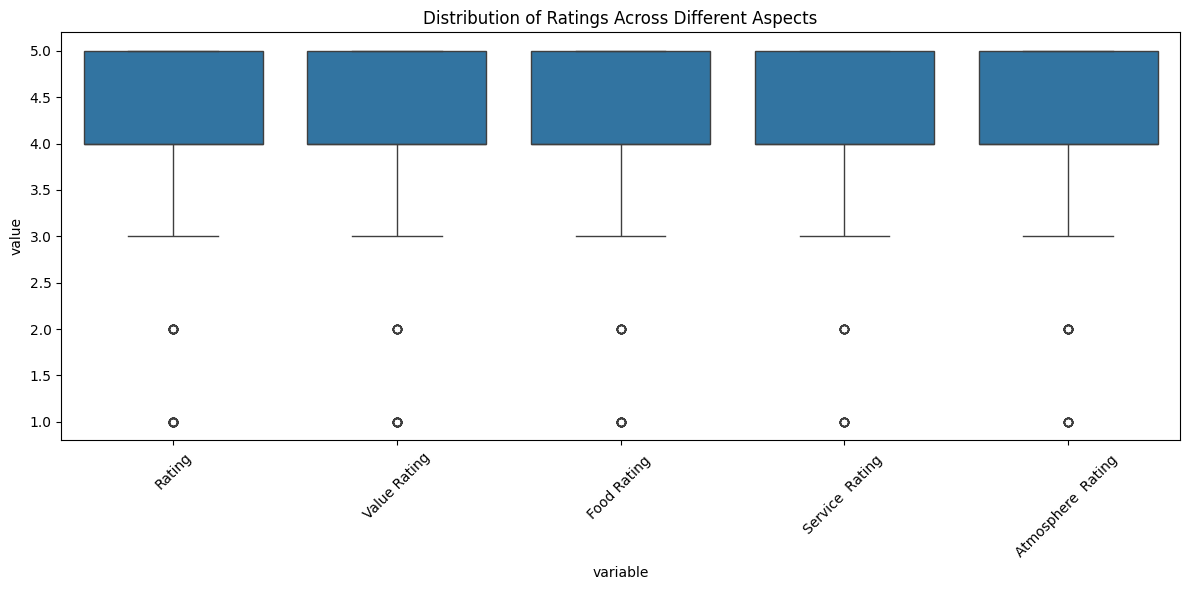

In [2]:
# Calculate correlations between ratings
rating_columns = ['Rating', 'Value Rating', 'Food Rating ', 'Service  Rating ', 'Atmosphere  Rating ']
correlation_matrix = df[rating_columns].corr()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Different Aspects of Dining Experience')
plt.tight_layout()
plt.show()

# Calculate average ratings for each aspect
avg_ratings = df[rating_columns].mean().sort_values(ascending=False)
print("\
Average Ratings for Each Aspect:")
print(avg_ratings)

# Prepare data for ML analysis
X = df[['Value Rating', 'Food Rating ', 'Service  Rating ', 'Atmosphere  Rating ']]
y = df['Rating']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.show()

# Print feature importance
feature_importance = pd.DataFrame(
    abs(pca.components_[0]),
    index=['Value', 'Food', 'Service', 'Atmosphere'],
    columns=['Importance']
).sort_values('Importance', ascending=False)

print("\
Feature Importance based on First Principal Component:")
print(feature_importance)

# Create box plots for each aspect
plt.figure(figsize=(12, 6))
df_melted = df[rating_columns].melt()
sns.boxplot(x='variable', y='value', data=df_melted)
plt.xticks(rotation=45)
plt.title('Distribution of Ratings Across Different Aspects')
plt.tight_layout()
plt.show()

Model Performance Metrics:
Mean Squared Error: 0.5998
R-squared Score: 0.5758


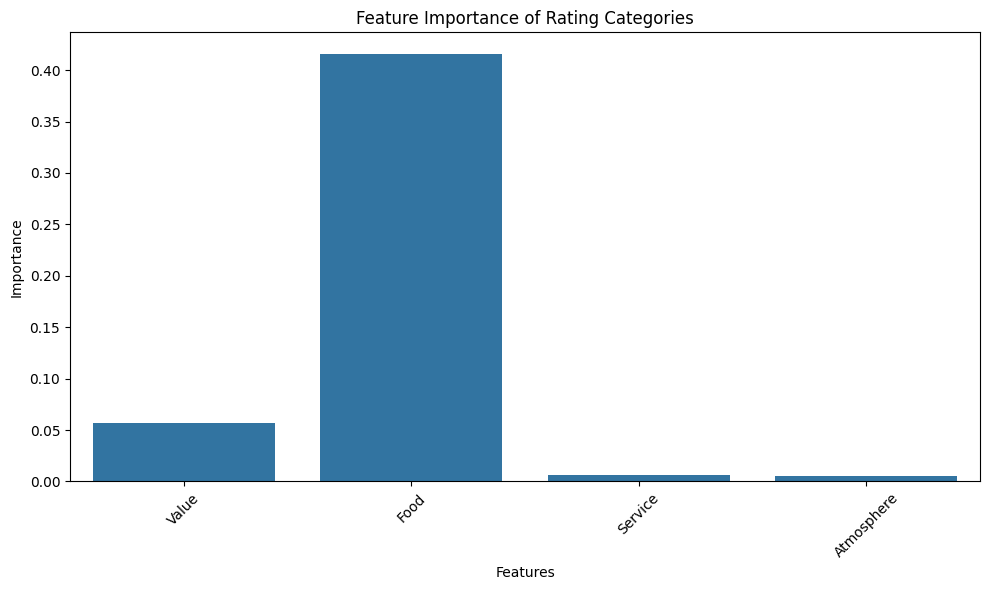

Top 10 Most Important Words in Reviews:
          word  importance
566    ordered    0.130646
722       rude    0.043443
313       good    0.021468
521       need    0.015950
554         ok    0.009136
978       wine    0.008033
864  tasteless    0.007822
327        guy    0.007185
617      place    0.007101
69         bit    0.006564


In [3]:
#Step 2 - Same question Different method
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Read and prepare the data
df = pd.read_csv('Cleaned_Dolche_Vita_Reviews.csv')

# Text preprocessing for reviews
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
review_features = vectorizer.fit_transform(df['Review'].fillna(''))

# Combine text features with numerical ratings
X_ratings = df[['Value Rating', 'Food Rating ', 'Service  Rating ', 'Atmosphere  Rating ']]
X_combined = np.hstack((review_features.toarray(), X_ratings))

# Target variable
y = df['Rating']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Feature importance for numerical features
rating_importance = rf_model.feature_importances_[-4:]
rating_features = ['Value', 'Food', 'Service', 'Atmosphere']

plt.figure(figsize=(10, 6))
sns.barplot(x=rating_features, y=rating_importance)
plt.title('Feature Importance of Rating Categories')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Most important words from reviews
word_importance = rf_model.feature_importances_[:-4]
word_features = vectorizer.get_feature_names_out()
word_importance_df = pd.DataFrame({
    'word': word_features,
    'importance': word_importance
}).sort_values('importance', ascending=False)

print("\
Top 10 Most Important Words in Reviews:")
print(word_importance_df.head(10))